Extension of m2.3, this time removing the FPN portion of Darknet and only using the (highest resolution) feature map on the downsampling path. This is removing aroun 60% of the network (in terms of number of convolutional layers). This has a noticeable effect on inference time, down to 28 seconds from 44 seconds and the accuracy remains as strong. However the inference time is still not fast enough, it needs to be around 10-15 seconds.

Also introduced evaluation of model within notebook and differentiate between nms_iou_threshold (used to dedupe overlapping predictions) and eval_iou_threshold (used to define positive predictions)

In [1]:
cd ..

/mnt/c/Users/macle/Dropbox/mcode/SerpentAI


In [2]:
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detector.pytorch_detector import PytorchObjectDetector
import skimage.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ptyolov3.test import evaluate

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
model_path = 'ml_train/station_detector/pytorch/models/m2.3.1/checkpoints/station_detector_pt_yolov3_m2.3.1_cpkt_40.pth'
config_path = 'ml_train/station_detector/pytorch/models/m2.3.1/yolov3-custom.cfg'
labels_path = None
img_size = 416
nms_conf_threshold = 0.3
nms_iou_threshold = 0.1
eval_iou_threshold = 0.5

In [4]:
station_detector = PytorchObjectDetector(model_path, config_path, labels_path, img_size)

### Running inference and plotting results on 'test' images

In [5]:
img_paths = list(Path("ml_train/station_detector/pytorch/data/test").glob("*.png"))
img_filenames = [img_path.name for img_path in img_paths]

In [6]:
%%time
images = [skimage.io.imread(img_path) for img_path in img_paths]

detection_results = [station_detector.predict(image, nms_conf_threshold, nms_iou_threshold) for image in images] 

CPU times: user 1min 16s, sys: 2.88 s, total: 1min 19s
Wall time: 42.4 s


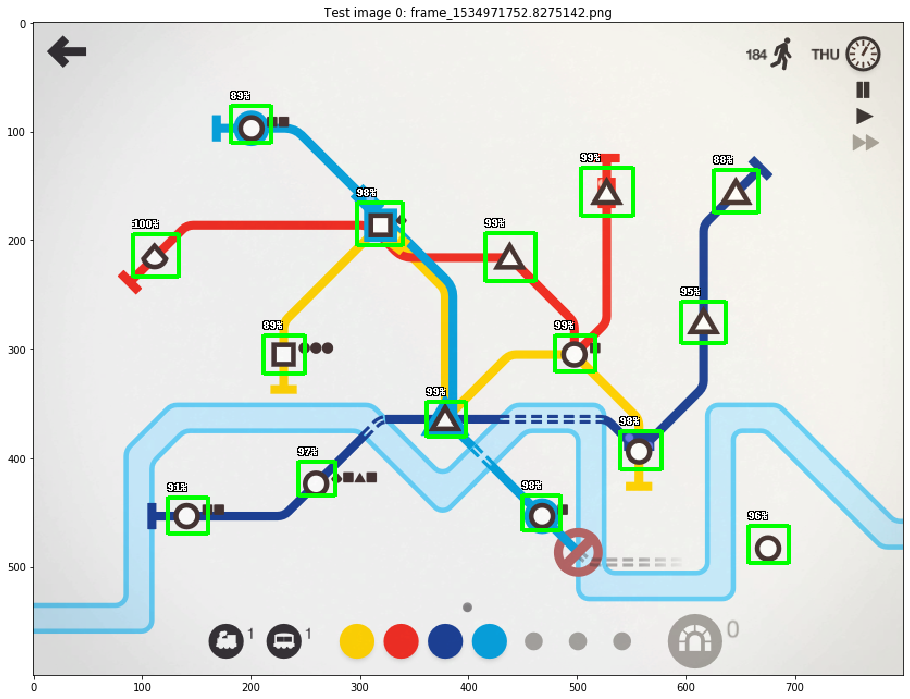

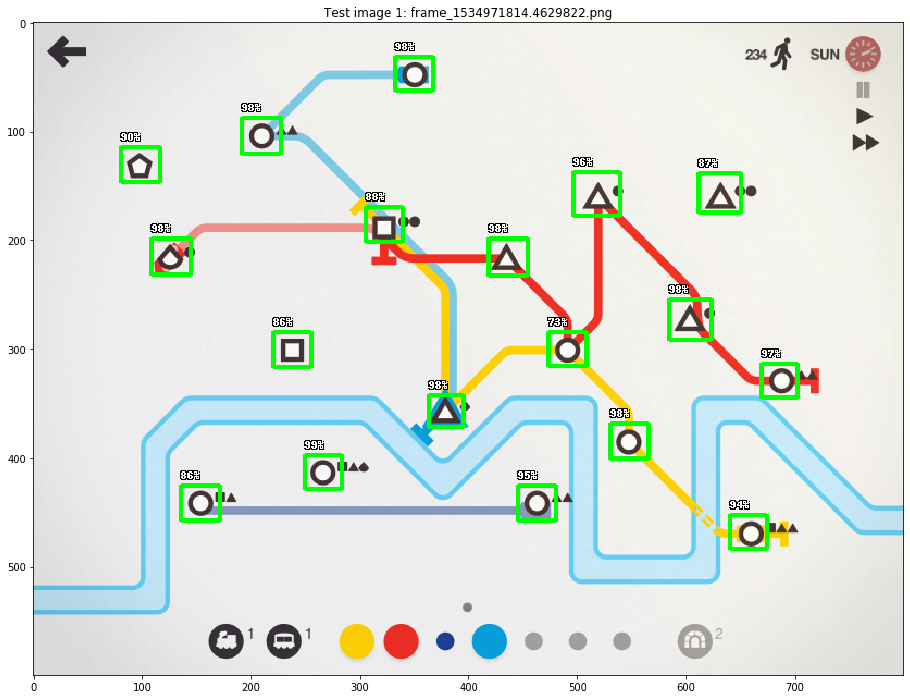

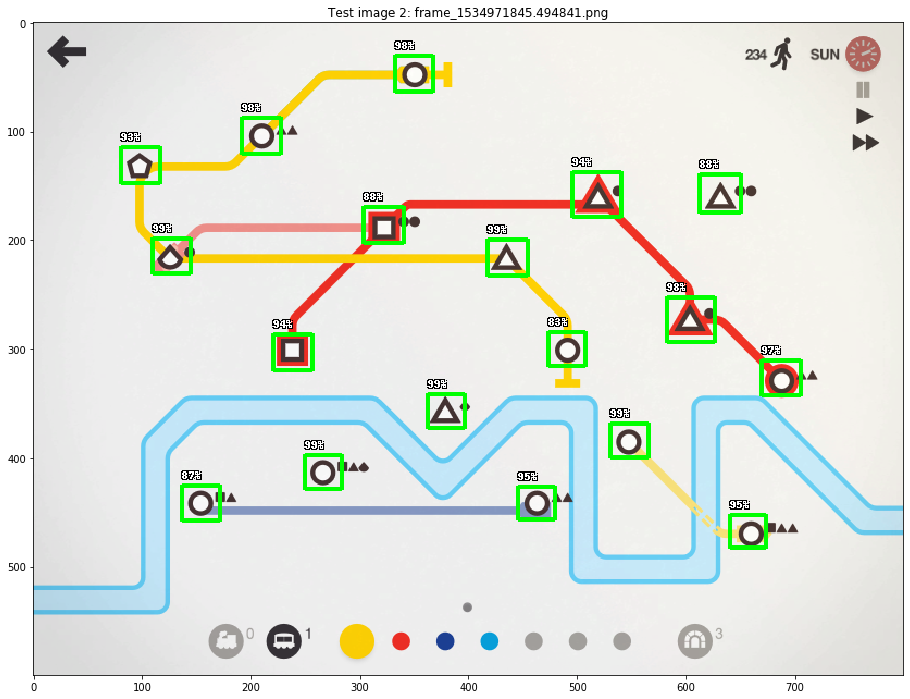

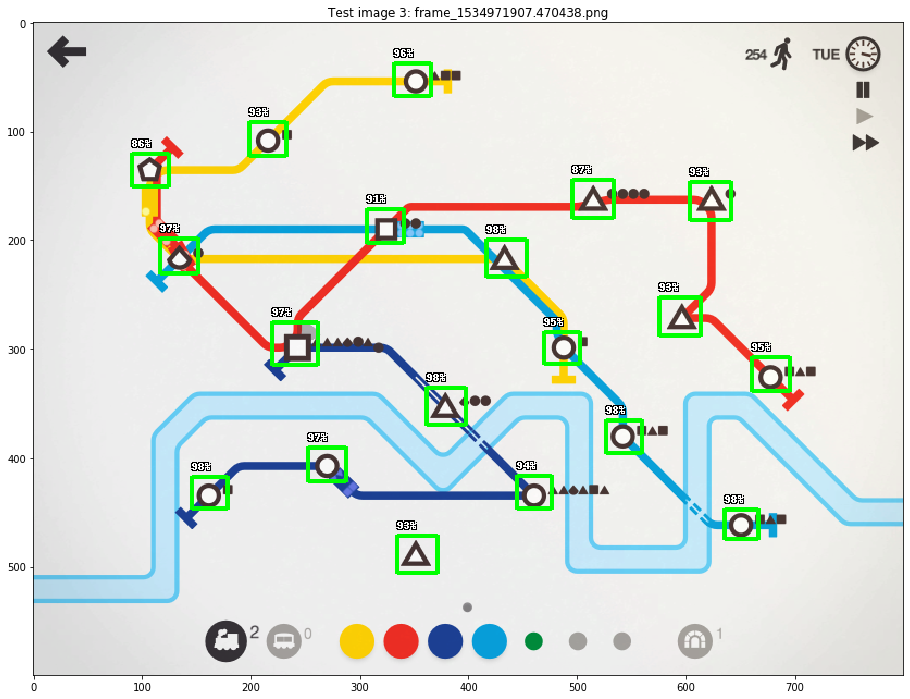

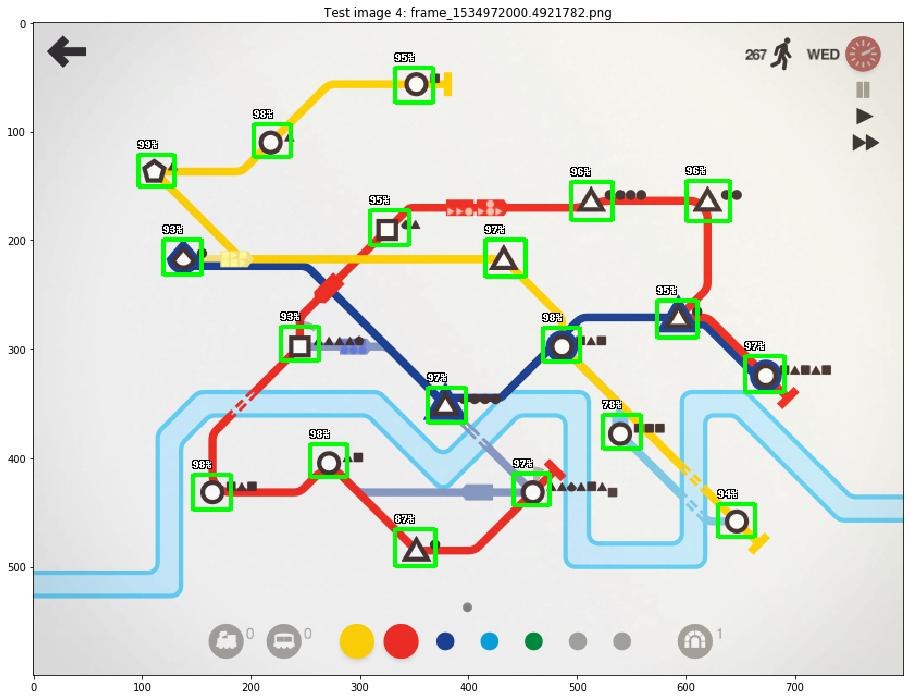

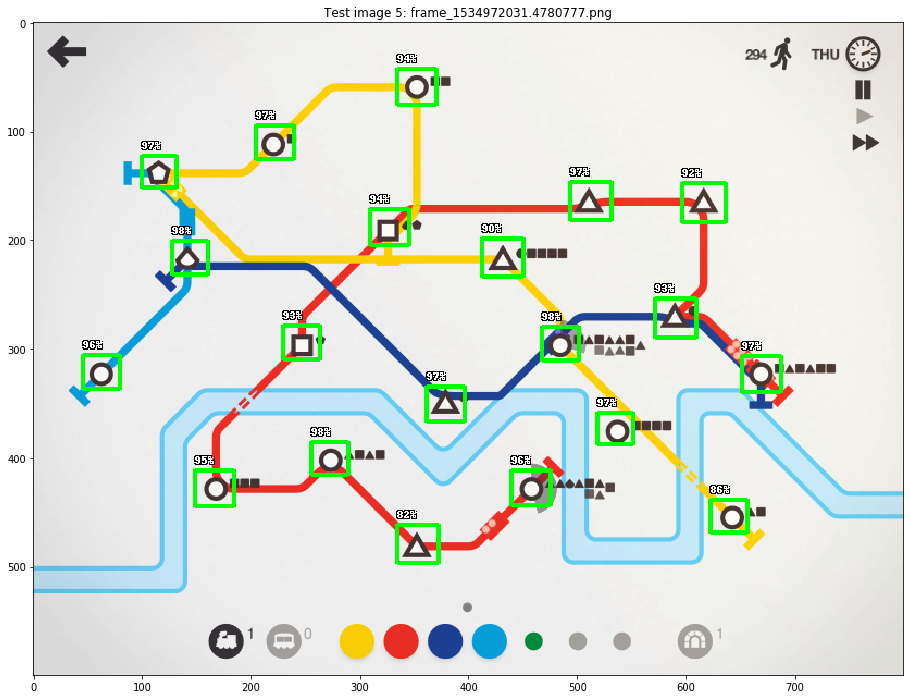

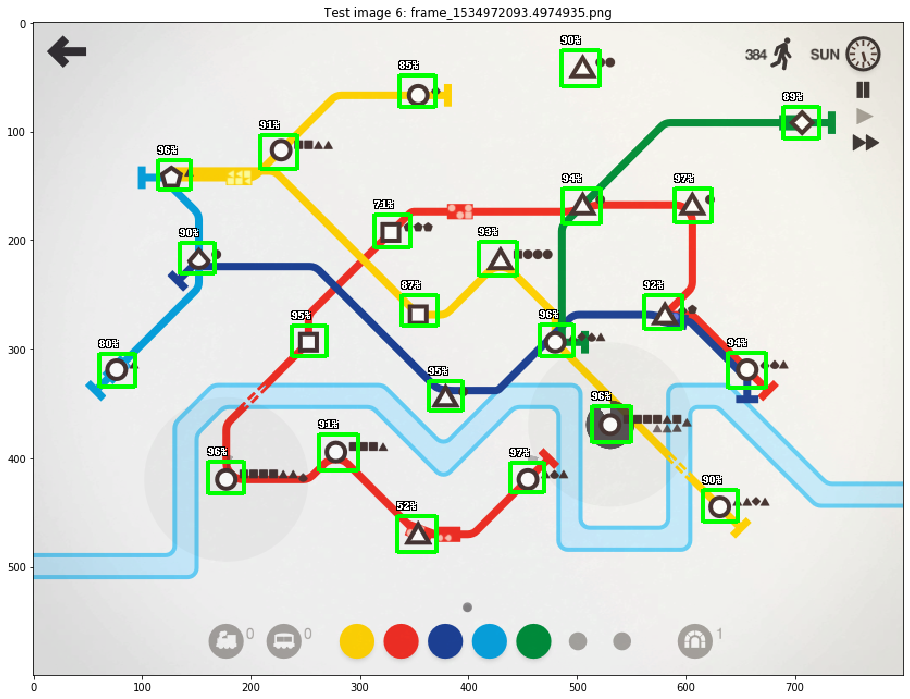

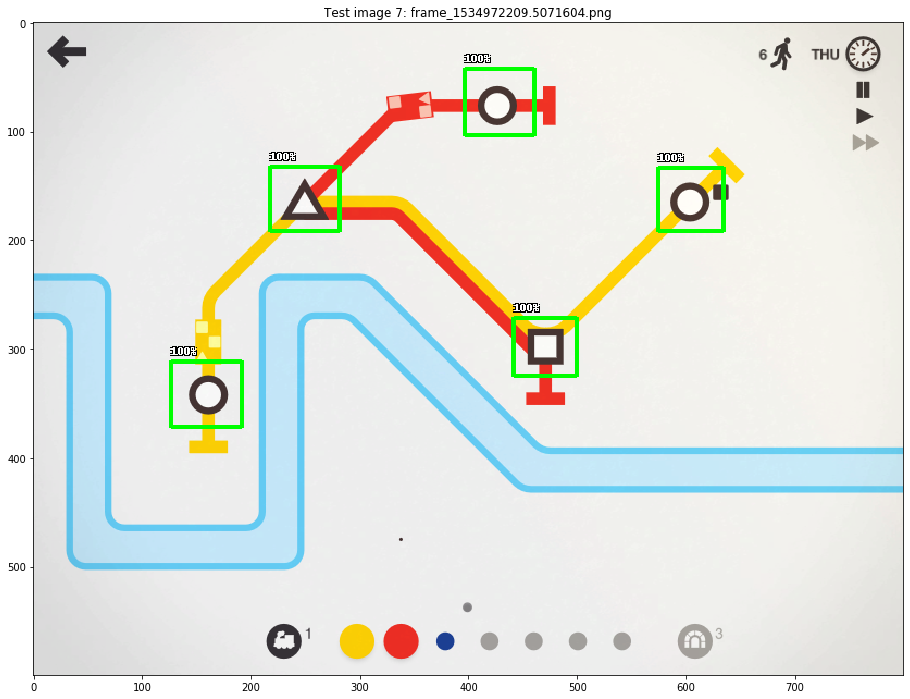

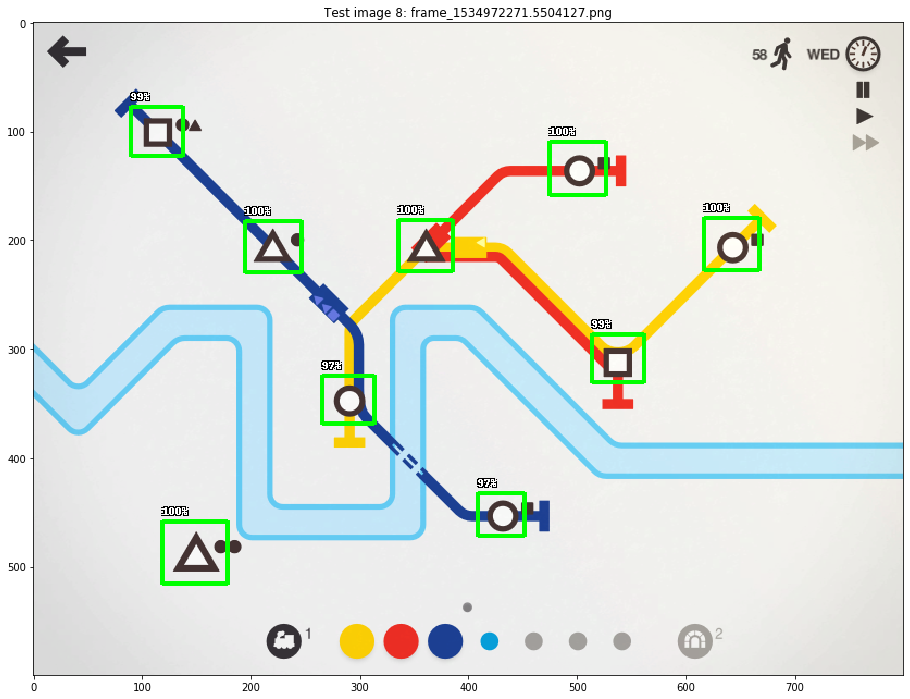

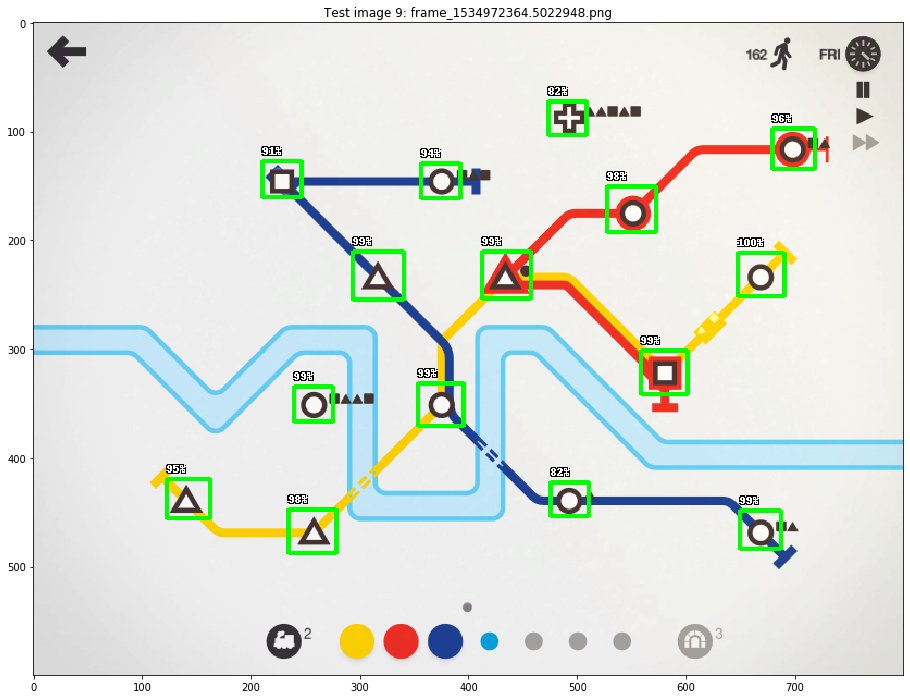

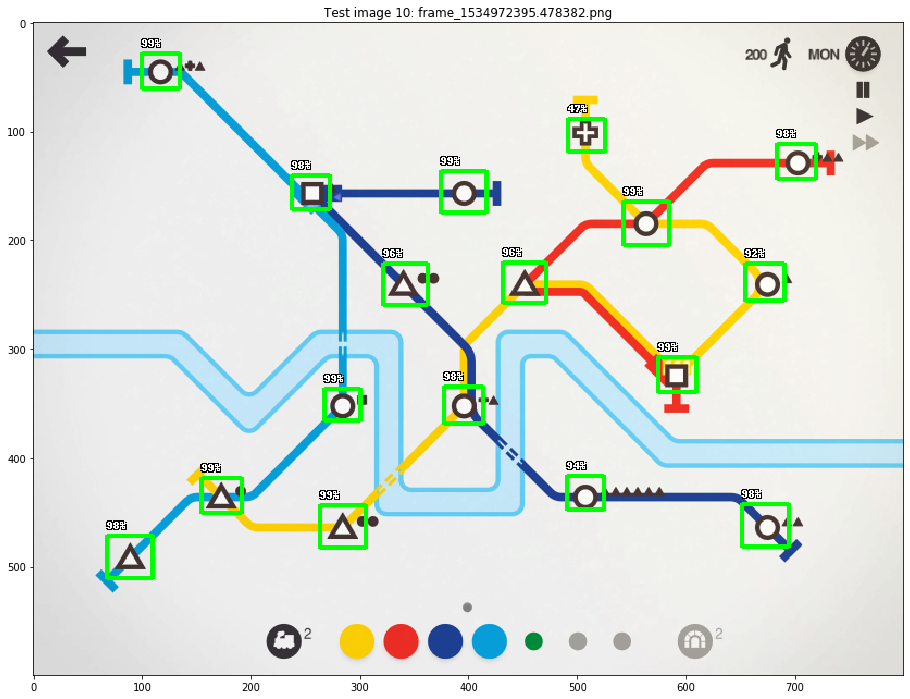

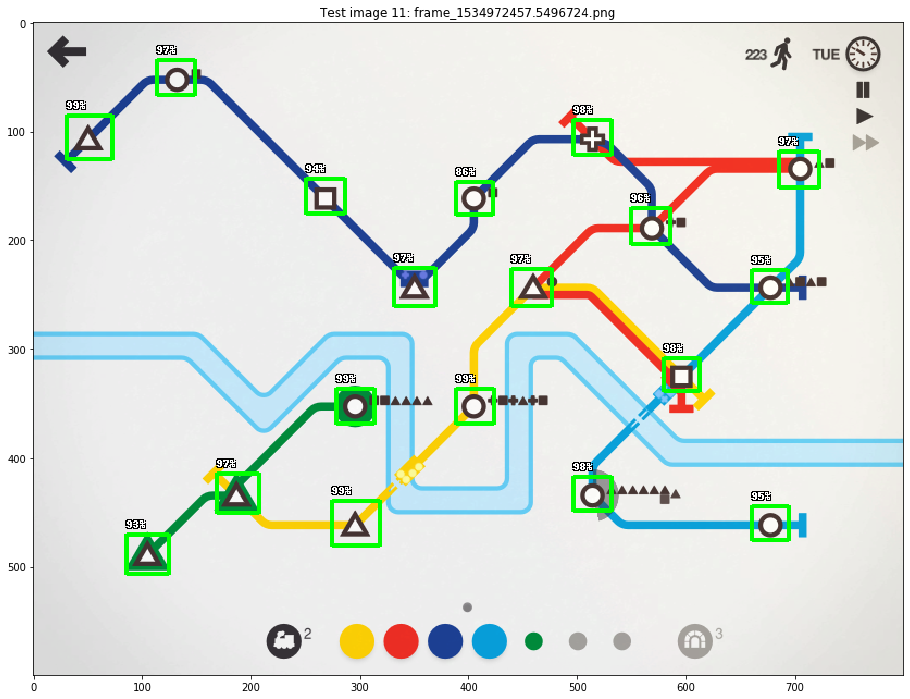

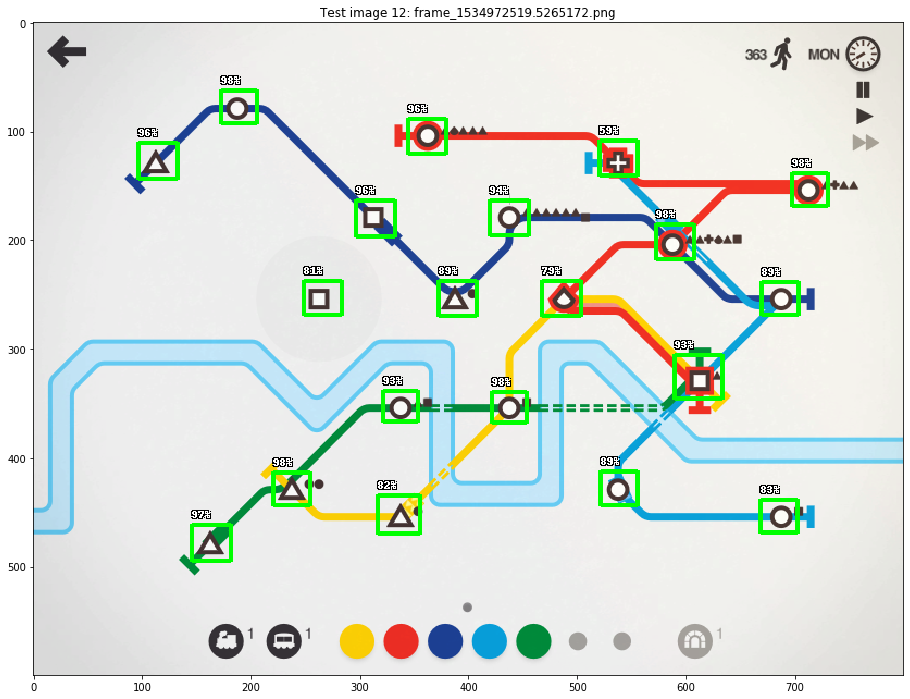

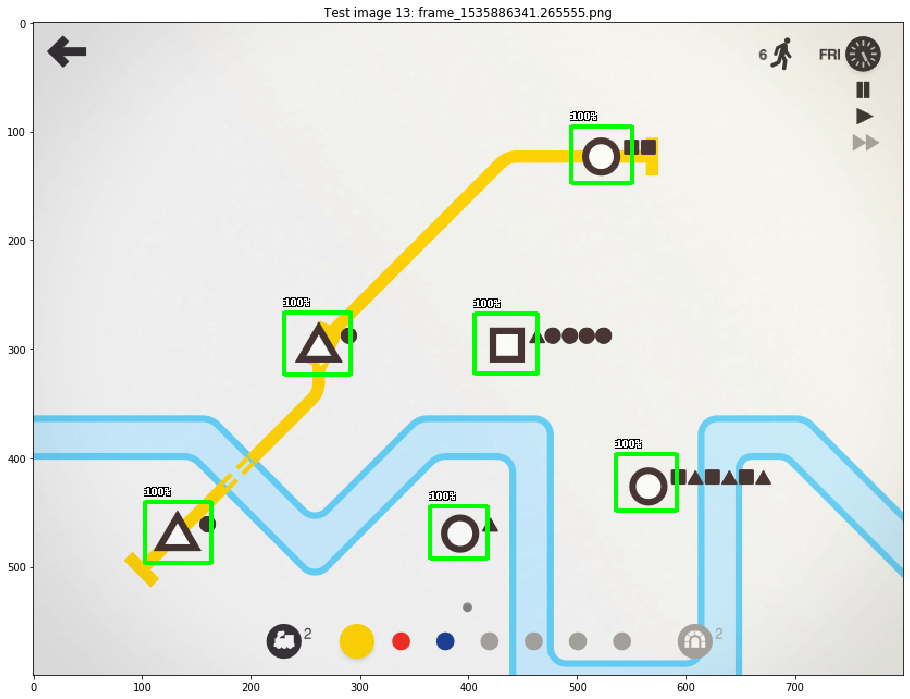

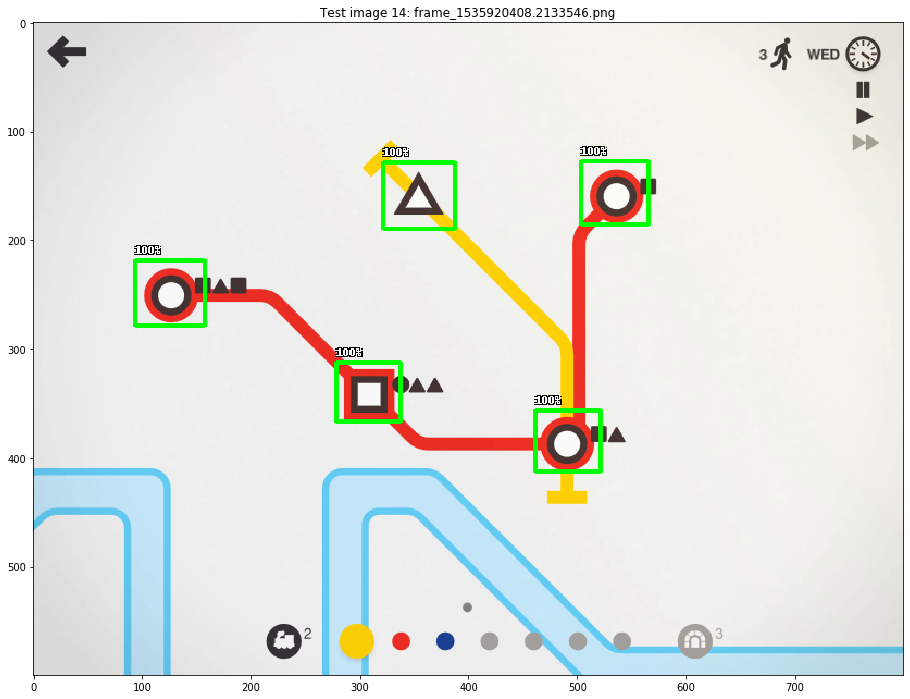

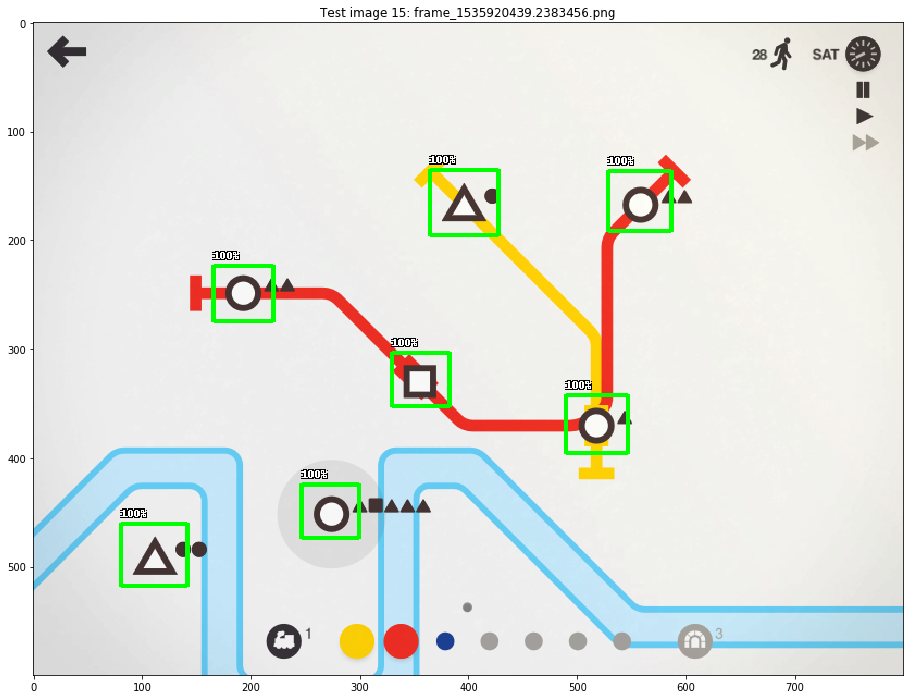

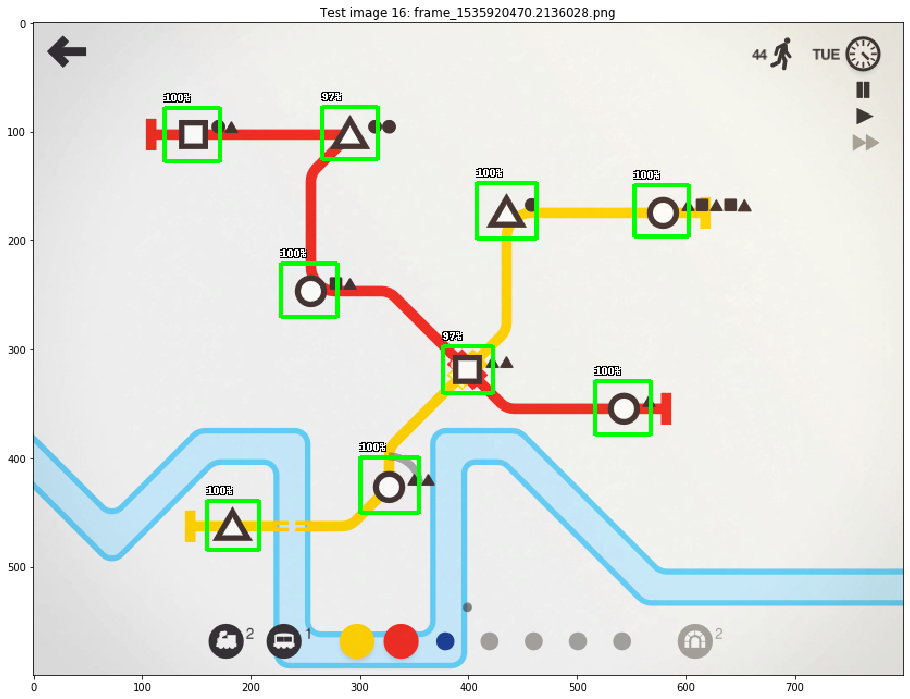

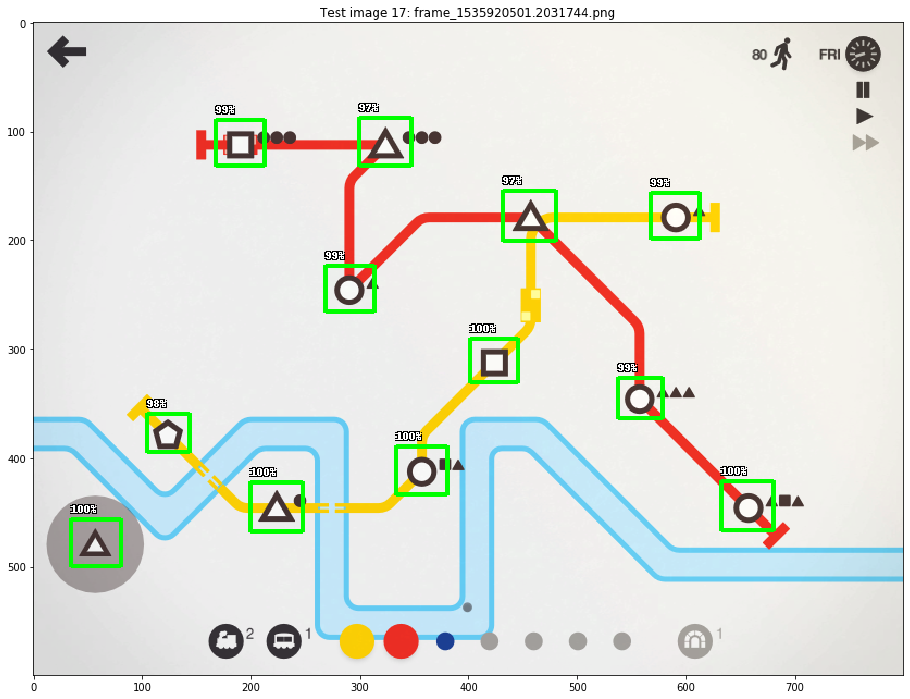

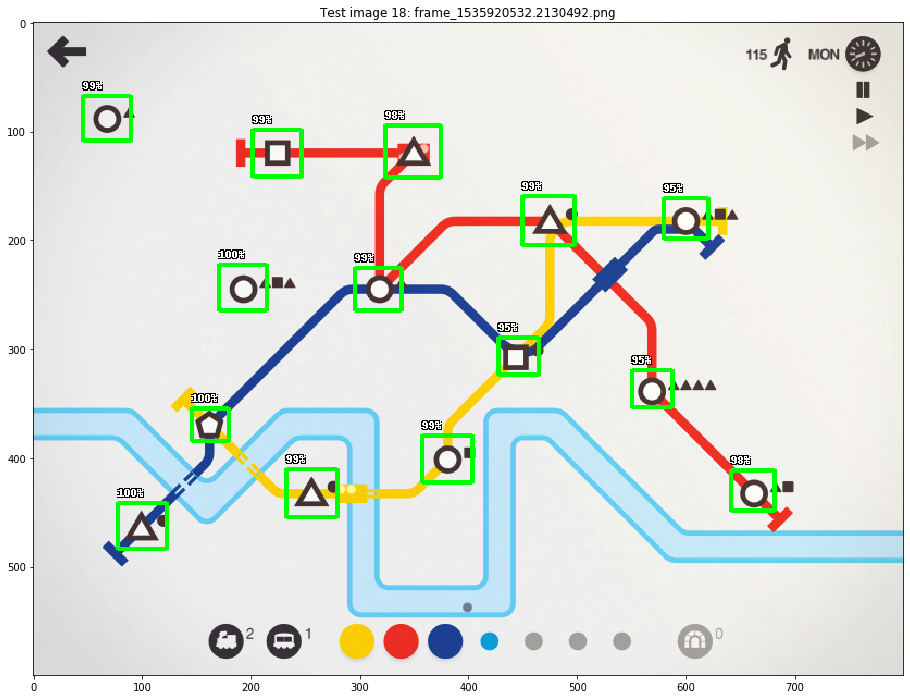

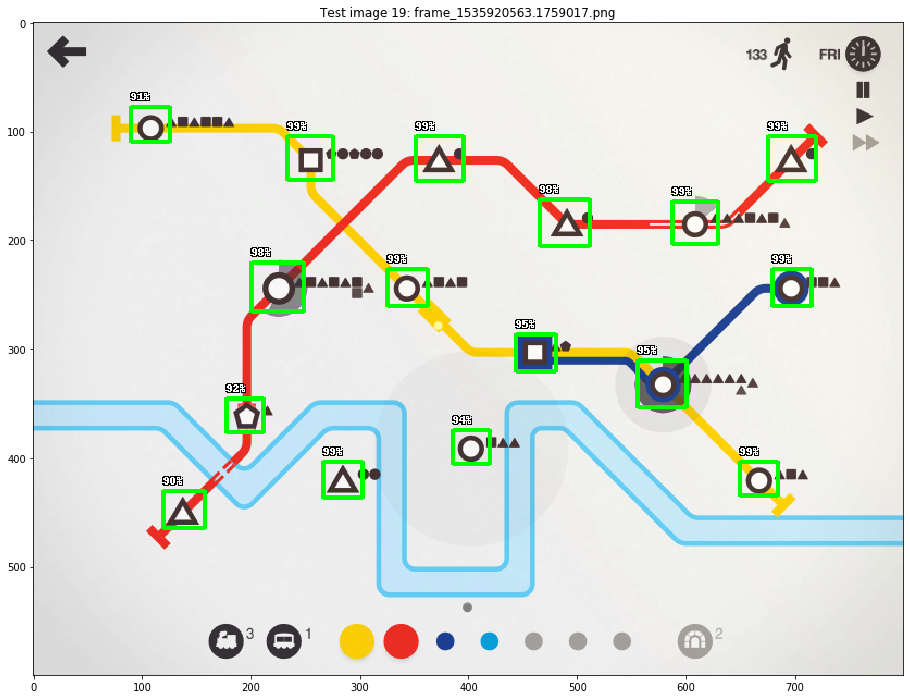

In [7]:
for i, (image, img_filename, detection_result) in enumerate(zip(images, img_filenames, detection_results)):
    _, ax = plt.subplots(figsize=(22,12))
    image_box = station_detector.draw_bounding_boxes(image, **detection_result) 
    ax.set_title(f"Test image {i}: {img_filename}")
    ax.imshow(image_box);

In [8]:
cd ml_train/station_detector/pytorch/

/mnt/c/Users/macle/Dropbox/mcode/SerpentAI/ml_train/station_detector/pytorch


In [9]:
precision, recall, AP, f1, ap_class = evaluate(
    station_detector.model,
    path='data/test.txt',
    iou_thres=eval_iou_threshold,
    conf_thres=nms_conf_threshold,
    nms_thres=nms_iou_threshold,
    img_size=img_size,
    batch_size=10
)

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 102.71it/s]


In [10]:
print('mAP:', AP.mean())

mAP: 0.9965034965034965
